In [1]:
import MGTomo.model as mgmodel
import numpy as np
import time
import MGTomo.tomoprojection as mgproj
from MGTomo.utils import myexp, mylog, mydiv, mysub
import MGTomo.functions as fcts
from skimage import data
from skimage.transform import resize
from MGTomo.optimize import armijo_linesearch_box, box_bounds

from MGTomo.gridop import P,R, RBox, PBox

import torch
from torch.func import grad

from torch.linalg import matrix_norm

import matplotlib.pyplot as plt 

In [2]:
max_levels = 1
maxIter = [5,5]

In [3]:
N = 255
# load image
x_orig = data.shepp_logan_phantom()
x_orig = resize(x_orig, (N,N), anti_aliasing = False)

x_torch = torch.tensor(x_orig, requires_grad = True)

In [4]:
model = mgmodel.astra_model(N,{'mode' : 'line', 'num_angles' : 50, 'level_decrease' : 1})
fine_dim = model.dim
A = [mgproj.TomoTorch(model.proj_factory(fine_dim))]
b = [A[0](x_torch)]
level = {int(np.sqrt(A[0].shape[1])): 0}

for i in range(1,max_levels+1):
    coarse_dim = model.reduce_dim(fine_dim)
    A.append(mgproj.TomoTorch(model.proj_factory(coarse_dim)))
    b.append(torch.from_numpy(model.reduce_rhs(b[-1].detach().numpy(), fine_dim, coarse_dim)))
    level.update({int(np.sqrt(A[i].shape[1])): i})
    fine_dim=coarse_dim

In [5]:
#c0 = A[0].sumnorm()
c0 = 100
tau0 = 0.5 * 1/c0

In [6]:
fh = lambda x: fcts.kl_distance(x, A[0], b[0])

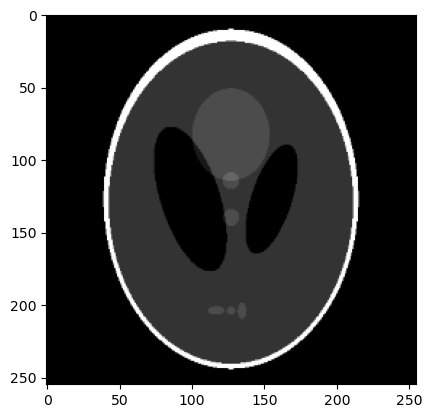

In [20]:
plt.imshow(x_orig, cmap = 'gray')

## Test relative L-smoothness of fh

In [7]:
def Dfhst(s,t):
    fhs = fh(s)
    fht = fh(t)
    fht.backward(retain_graph = True)
    grad_fh_t = t.grad.clone()
    #print(y0.grad)
    Dfhst = fhs - fht - torch.sum(grad_fh_t * (s-t))
    
    return Dfhst

def Klst(s,t):
    st = mydiv(s,t)
    KLst_zw = s* mylog(st) + s - t

    KLst = torch.sum( KLst_zw[t > 0.] ) + 0.5*torch.sum(st[t == 0.]**2)
    
    return KLst

In [8]:
for i in range(5):
    s = torch.rand(N, N, requires_grad = True)
    t = torch.rand(N, N, requires_grad = True)
    
    assert Dfhst(s,t) <= c0 * Klst(s,t)

In [23]:
for i in range(5):
    z0 = torch.rand(N, N, requires_grad = True)
    z1 = fcts.SMART(fh, z0, tau0)
    
    assert fh(z1) - fh(z0) <=0, fh(z1) - fh(z0)

In [24]:
z0 = torch.rand(N, N, requires_grad = True)
fhz0 = fh(z0)
for i in range(100):
    val = fcts.SMART(fh, z0, tau0)
    assert fh(val) - fh(z0) <= 0, fh(val) - fh(z0)
    z0 = val.clone().detach().requires_grad_(True)
    
    assert z0.grad is None
print(fh(z0)/fhz0)

KeyboardInterrupt: 

In [7]:
plt.imshow(z0.detach().numpy(), cmap = 'gray')

NameError: name 'z0' is not defined

In [ ]:
for i in range(5):
    z0 = torch.rand(N, N, requires_grad = True)
    z1 = fcts.BSMART(fh, z0, tau0)
    
    assert fh(z1) - fh(z0) <=0, fh(z1) - fh(z0)

In [8]:
z0 = torch.rand(N, N, requires_grad = True)
fhz0 = fh(z0)
for i in range(100):
    val = fcts.BSMART(fh, z0, tau0)
    assert fh(val) - fh(z0) <= 0, fh(val) - fh(z0)
    z0 = val.clone().detach().requires_grad_(True)
    
    assert z0.grad is None
print(fh(z0)/fhz0)

KeyboardInterrupt: 

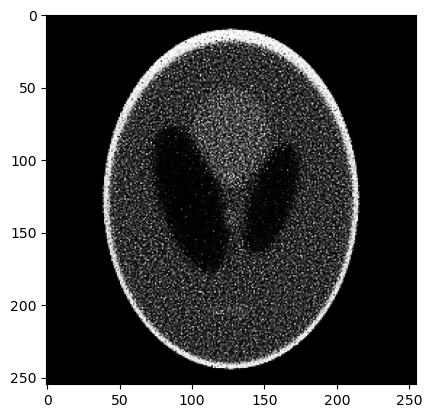

In [ ]:
plt.imshow(z0.detach().numpy(), cmap = 'gray')

# Setup coarse model

In [7]:
y0 = torch.ones(N, N)*0.5
y0.requires_grad = True

In [8]:
x0 = R(y0)
x0.retain_grad()

x0 = x0.clone().detach().requires_grad_(True)
#print(x0)

fH = lambda x: fcts.kl_distance(x, A[1], b[1])

fhy0 = fh(y0)
fhy0.backward(retain_graph = True)

fHx0 = fH(x0)
fHx0.backward(retain_graph = True)

kappa = R(y0.grad) - x0.grad
y0.grad.zero_()

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [9]:
def psi(x):
    val = fH(x) + torch.sum(kappa * x)
    return val

## Test coarse model psi and coarse function fH properties

In [10]:
def DfHuv(u,v):
    fHu = fH(u)
    fHv = fH(v)
    fHv.backward(retain_graph = True)
    grad_fH_v = v.grad.clone()
    #print(y0.grad)
    DfHuv = fHu - fHv - torch.sum(grad_fH_v * (u-v))
    return DfHuv

def Dpsiuv(u,v):
    psiu = psi(u)
    psiv = psi(v)
    #print(y0.grad)
    psiv.backward()
    #print(y0.grad)
    Dpsiuv = psiu - psiv - torch.sum(v.grad * (u-v))
    
    return Dpsiuv

In [10]:
#c1 = A[1].sumnorm()
c1 = c0
tau1 = 0.5 * 1/c1

In [11]:
NH = int(np.floor(N/2))

In [ ]:
for i in range(100):
    u = torch.rand(NH,NH, requires_grad = True)
    v = torch.rand(NH,NH, requires_grad = True)
    
    Kl = Klst(u,v)

    Dpsi = Dpsiuv(u,v)
    v.grad.zero_()
    DfH = DfHuv(u,v)
    v.grad.zero_()
    
    assert Dpsi - c1*Kl <=0.1, Dpsi - c1*Kl
    assert DfH - c1*Kl <= 0.1, Dpsi - c1*Kl
    
    assert (Dpsi - DfH).abs() <= 0.5, Dpsi - DfH

AssertionError: tensor(-2.2891, dtype=torch.float64, grad_fn=<SubBackward0>)

## Test psi and SMART

In [ ]:
for i in range(5):
    z0 = torch.rand(NH, NH, requires_grad = True)
    z1 = fcts.SMART(psi, z0, tau1)
    
    assert psi(z1) - psi(z0) <=0, psi(z1) - psi(z0)

In [ ]:
z0 = torch.rand(NH, NH, requires_grad = True)
for i in range(5):
    val = fcts.SMART(psi, z0, tau1)
    assert psi(val) - psi(z0) <= 0, psi(val) - psi(z0)
    z0 = val.clone().detach().requires_grad_(True)
    assert z0.min() >= 0
    assert z0.grad is None

## Test psi and BSMART

In [13]:
for i in range(100):
    z0 = torch.rand(NH, NH, requires_grad = True)
    z1 = fcts.BSMART(psi, z0, tau1)
    
    assert psi(z1) - psi(z0) <=0, psi(z1) - psi(z0)

In [21]:
z0 = torch.rand(NH, NH, requires_grad = True)
for i in range(200):
    val = fcts.BSMART(psi, z0, tau1)
    assert psi(val) - psi(z0) <= 0, psi(val) - psi(z0)
    z0 = val.clone().detach().requires_grad_(True)
    assert z0.min() >= 0
    assert z0.grad is None

In [33]:
tau = [tau1, tau1]

In [34]:
def coarse_condition(y, grad_y, kappa, y_last = None):
    gcond = (matrix_norm(R(grad_y), ord = 1) >= kappa * matrix_norm(grad_y, ord = 1))
    if y_last is not None:
        y_diff_norm = matrix_norm(y_last - y, ord = 1)
        return gcond and (y_diff_norm >= kappa)
    else:
        return gcond
    
def MLO_box(fh, y, last_pts: list, l=0, kappa = 0.5, verbose = True):
    x = RBox(y).detach().requires_grad_(True)
    y0, x0 = y, x.clone().detach().requires_grad_(True)
    
    fhy0 = fh(y0)
    fhy0.backward(retain_graph = True)
    grad_fhy0 = y0.grad.clone()
    y0.grad.zero_()
    
    #print('coarse correction at l = ', l)
    if coarse_condition(y, grad_fhy0, kappa, last_pts[l]):
        print(l, ' : coarse correction activated')
        
        last_pts[l] = y0.clone().detach()
    
        fH = lambda x: fcts.kl_distance(x, A[l+1], b[l+1])
        fHx0 = fH(x0)
        fHx0.backward(retain_graph = True)
        grad_fHx0 = x0.grad.clone()
        x0.grad.zero_()

        kappa = RBox(grad_fhy0) - grad_fHx0

        psi = lambda x: fH(x) + torch.sum(kappa * x)
        
        for i in range(maxIter[l]):
            x.retain_grad()
            val = fcts.BSMART(psi, x, tau[l+1])
            x = val.clone().detach().requires_grad_(True)
            
        if l < max_levels-1:
            x, last_pts, _ = MLO_box(psi, x, last_pts, l+1)

        assert psi(x) <= fH(x0) + torch.sum(kappa * x0), 'psi(x) < psi(x0) = fH(x0) does not hold'
    else: 
        print(l, ' : coarse correction not activated')
    
    d = PBox(x-x0)
    z, a = armijo_linesearch_box(fh, y0, d, verbose = verbose)
    
    assert z.min() >= 0
    
    for i in range(maxIter[l]):
        z.retain_grad()
        zval = fcts.BSMART(fh, z, tau[l])
        y0.grad.zero_()
        z = zval.clone().detach().requires_grad_(True)
    return z, last_pts, a


In [35]:
a = []
z0 = torch.rand(N, N, requires_grad = True)
fhz0 = fh(z0)
last_pts = [None]*(max_levels+1)


iteration_times = []
overall_start_time = time.process_time()  # Start overall timing

fval = []

for i in range(100):
    iteration_start_time = time.process_time()  # Start timing for this iteration
    
    val, ylast, alpha = MLO_box(fh, z0, last_pts, verbose=False)
    z0 = val.clone().detach().requires_grad_(True)
    a.append(alpha)
    
    iteration_end_time = time.process_time()  # End timing for this iteration
    iteration_time = iteration_end_time - iteration_start_time  # Calculate elapsed time for this iteration
    iteration_times.append(iteration_time)

    fval.append(fh(z0).detach().numpy())
    
    print(f"Iteration {i}: {fh(z0)} - Time: {iteration_time:.6f} seconds")

overall_end_time = time.process_time()  # End overall timing
overall_time = overall_end_time - overall_start_time  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time:.6f} seconds")

0  : coarse correction activated
Iteration 0: 72821.50801011591 - Time: 28.284122 seconds
0  : coarse correction activated
Iteration 1: 26254.560619520616 - Time: 27.579569 seconds
0  : coarse correction activated
Iteration 2: 13695.353724566517 - Time: 26.547375 seconds
0  : coarse correction activated


KeyboardInterrupt: 

In [ ]:
cumaltive_times = [sum(iteration_times[:i+1]) for i in range(len(iteration_times))]

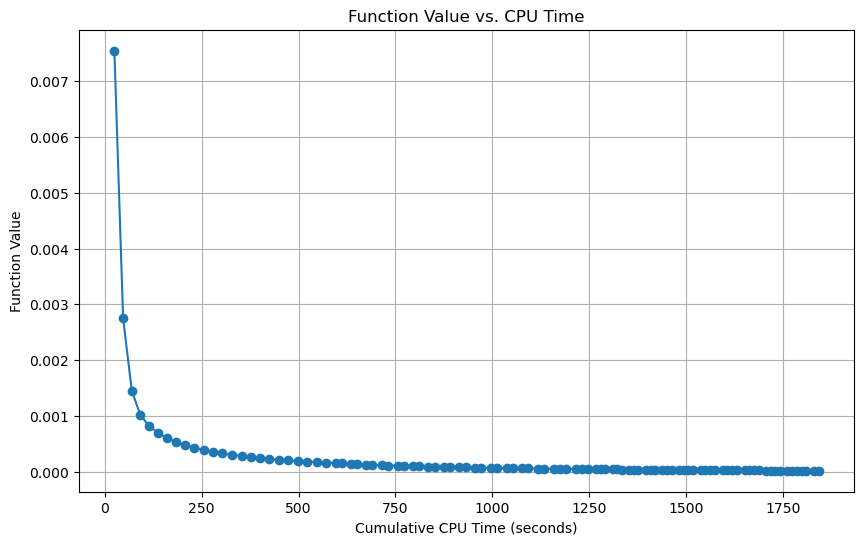

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(cumaltive_times, fval, marker='o', linestyle='-')
plt.xlabel('Cumulative CPU Time (seconds)')
plt.ylabel('Function Value')
plt.title('Function Value vs. CPU Time')
plt.grid(True)
plt.show()

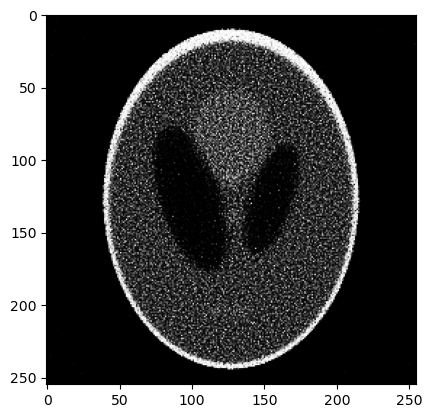

In [ ]:
plt.imshow(z0.detach().numpy(), cmap = 'gray')